In [12]:
#%pip install gymnasium
#%pip install torch

import gymnasium as gym
import numpy as np
import random

import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch

print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [13]:
env = gym.make("Blackjack-v1", natural=True, sab=False)
num_episodes = 200_000
gamma = 0.99 #współczynnik znaczenia przyszłej nagrody
actor_lr = 1e-4 #tempo uczenia aktorzyny
critic_lr = 5e-4 #tempo uczenia niekrytego krytyka
entropy_beta = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def state_to_tensor(state):

    player_sum, dealer_card, usable_ace = state
    x = np.array([
        player_sum / 32.0,
        dealer_card / 10.0,
        float(usable_ace)
    ], dtype=np.float32)

    return torch.tensor(x, dtype=torch.float32, device=device)


In [15]:
class Actor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x)


class Critic(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x).view(-1)



In [16]:
actor = Actor().to(device)
critic = Critic().to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

In [17]:
def a2c_select_action(state):
    state_tensor = state_to_tensor(state)
    probs = actor(state_tensor)
    dist = Categorical(probs=probs)
    action = dist.sample()

    value = critic(state_tensor)

    return action.item(), dist.log_prob(action), value

In [18]:
def a2c_greedy_action(state):
    with torch.no_grad():
        state_tensor = state_to_tensor(state)
        probs = actor(state_tensor)
        action = torch.argmax(probs).item()
    return action

In [19]:
def basic_strategy(state):
    player_sum, dealer_card, usable_ace = state
    if player_sum >= 17:
        return 0 
    else:
        return 1

In [20]:
def evaluate_policy(policy_fn, n_games=100_000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(n_games):
        state, _ = env.reset()
        done = False

        while not done:
            action = policy_fn(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    return wins, losses, draws

In [21]:
actor_losses = []
critic_losses = []
entropies = []

eval_every = 20_000
eval_n_games = 50_000
eval_steps = []
eval_winrate = []
eval_mean_return = []

In [22]:
episode_rewards_history = []

for episode in range(1, num_episodes + 1):
    state, _ = env.reset()
    done = False
    ep_reward = 0.0

    while not done:
        s_tensor = state_to_tensor(state)

        probs = actor(s_tensor)
        dist = Categorical(probs)
        entropy = dist.entropy().mean()

        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = critic(s_tensor)

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        ep_reward += reward

        if done:
            next_value = torch.tensor(0.0, device=device)
        else:
            ns_tensor = state_to_tensor(next_state)
            with torch.no_grad():
                next_value = critic(ns_tensor)

        td_target = reward + gamma * next_value
        advantage = td_target - value

        actor_loss = -(log_prob * advantage.detach())
        critic_loss = advantage.pow(2)

        actor_losses.append(float(actor_loss.detach().cpu()))
        critic_losses.append(float(critic_loss.detach().cpu()))
        entropies.append(float(entropy.detach().cpu()))

        loss = actor_loss + critic_loss

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        loss.backward()
        actor_optimizer.step()
        critic_optimizer.step()

        state = next_state

    episode_rewards_history.append(ep_reward)

    if episode % eval_every == 0:
        w, l, d = evaluate_policy(a2c_greedy_action, n_games=eval_n_games)
        winrate = w / eval_n_games
        mean_ret = (w - l) / eval_n_games
        eval_steps.append(episode)
        eval_winrate.append(winrate)
        eval_mean_return.append(mean_ret)
        print(f"[EVAL] ep={episode} winrate={winrate:.4f} mean_return={mean_ret:.4f}")

    if episode % 10_000 == 0:
        avg_reward = np.mean(episode_rewards_history[-10_000:])
        print(f"Episode {episode}, średnia nagroda z ostatnich 10k epizodów: {avg_reward:.3f}")


Episode 10000, średnia nagroda z ostatnich 10k epizodów: -0.171
[EVAL] ep=20000 winrate=0.3856 mean_return=-0.1794
Episode 20000, średnia nagroda z ostatnich 10k epizodów: -0.162
Episode 30000, średnia nagroda z ostatnich 10k epizodów: -0.163
[EVAL] ep=40000 winrate=0.3781 mean_return=-0.1903
Episode 40000, średnia nagroda z ostatnich 10k epizodów: -0.162
Episode 50000, średnia nagroda z ostatnich 10k epizodów: -0.158
[EVAL] ep=60000 winrate=0.3786 mean_return=-0.1921
Episode 60000, średnia nagroda z ostatnich 10k epizodów: -0.158
Episode 70000, średnia nagroda z ostatnich 10k epizodów: -0.174
[EVAL] ep=80000 winrate=0.3815 mean_return=-0.1853
Episode 80000, średnia nagroda z ostatnich 10k epizodów: -0.162
Episode 90000, średnia nagroda z ostatnich 10k epizodów: -0.153
[EVAL] ep=100000 winrate=0.3774 mean_return=-0.1936
Episode 100000, średnia nagroda z ostatnich 10k epizodów: -0.146
Episode 110000, średnia nagroda z ostatnich 10k epizodów: -0.172
[EVAL] ep=120000 winrate=0.3828 mean_r

In [23]:
def a2c_policy(state):
    return a2c_greedy_action(state)

wins_a2c, losses_a2c, draws_a2c = evaluate_policy(a2c_policy)
wins_bs, losses_bs, draws_bs = evaluate_policy(basic_strategy)

print("A2C:          Wins:", wins_a2c, "Losses:", losses_a2c, "Draws:", draws_a2c)
print("BasicStrategy: Wins:", wins_bs,  "Losses:", losses_bs,  "Draws:", draws_bs)


A2C:          Wins: 42759 Losses: 48307 Draws: 8934
BasicStrategy: Wins: 41022 Losses: 48537 Draws: 10441


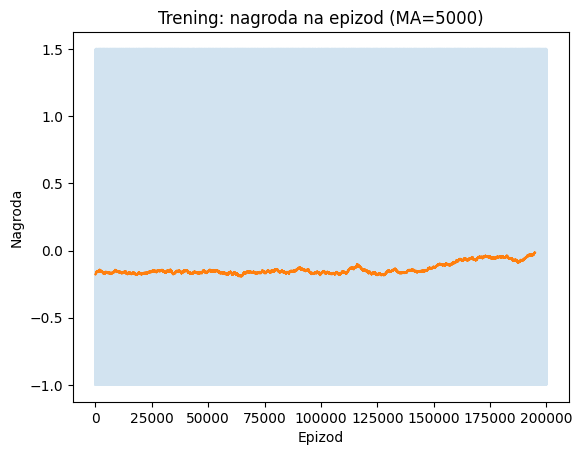

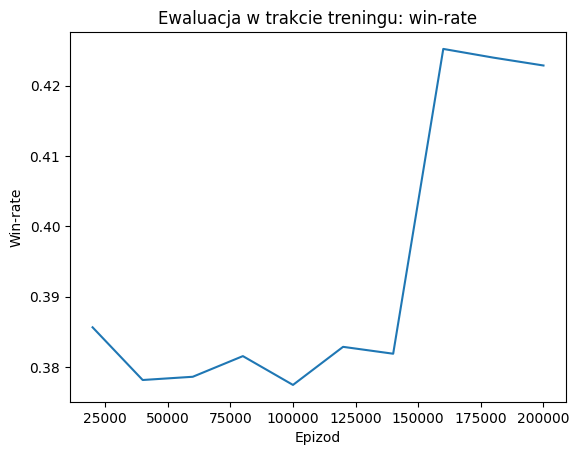

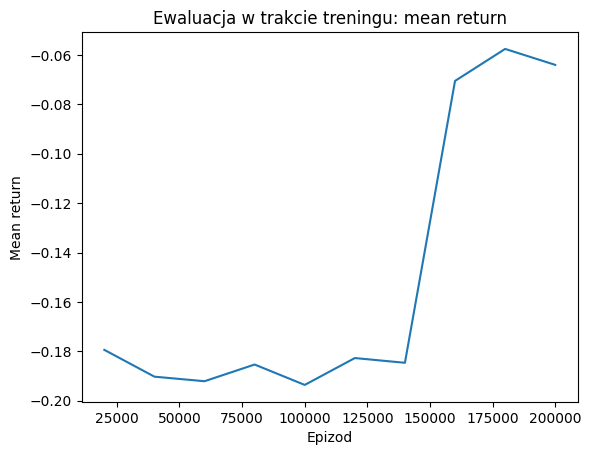

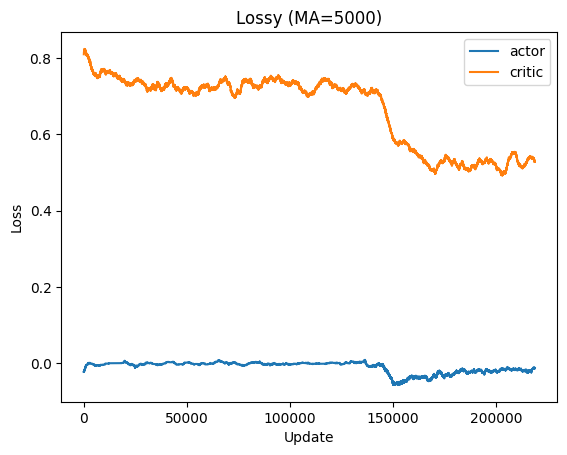

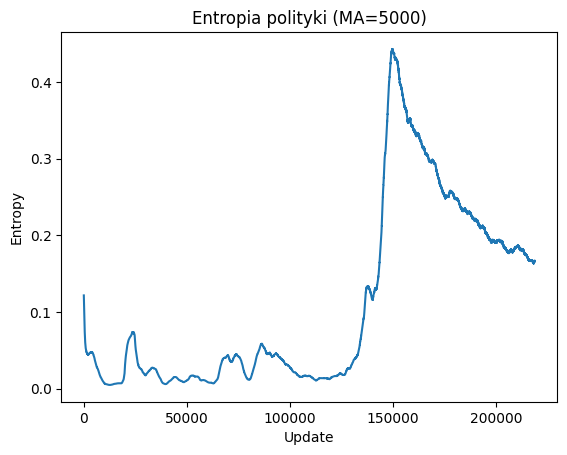

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(x, w):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w, dtype=np.float32)/w, mode="valid")

rewards = np.asarray(episode_rewards_history, dtype=np.float32)

plt.figure()
plt.plot(rewards, alpha=0.2)
plt.plot(moving_avg(rewards, 5000))
plt.title("Trening: nagroda na epizod (MA=5000)")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.show()

if "eval_steps" in globals() and len(eval_steps) > 0:
    plt.figure()
    plt.plot(eval_steps, eval_winrate)
    plt.title("Ewaluacja w trakcie treningu: win-rate")
    plt.xlabel("Epizod")
    plt.ylabel("Win-rate")
    plt.show()

    plt.figure()
    plt.plot(eval_steps, eval_mean_return)
    plt.title("Ewaluacja w trakcie treningu: mean return")
    plt.xlabel("Epizod")
    plt.ylabel("Mean return")
    plt.show()

if "actor_losses" in globals() and len(actor_losses) > 0:
    plt.figure()
    plt.plot(moving_avg(actor_losses, 5000), label="actor")
    plt.plot(moving_avg(critic_losses, 5000), label="critic")
    plt.title("Lossy (MA=5000)")
    plt.xlabel("Update")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

if "entropies" in globals() and len(entropies) > 0:
    plt.figure()
    plt.plot(moving_avg(entropies, 5000))
    plt.title("Entropia polityki (MA=5000)")
    plt.xlabel("Update")
    plt.ylabel("Entropy")
    plt.show()


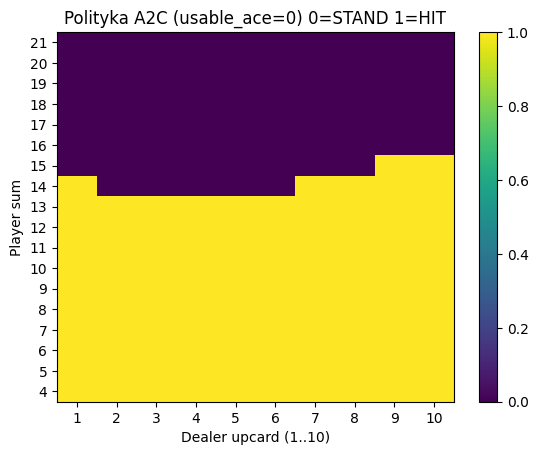

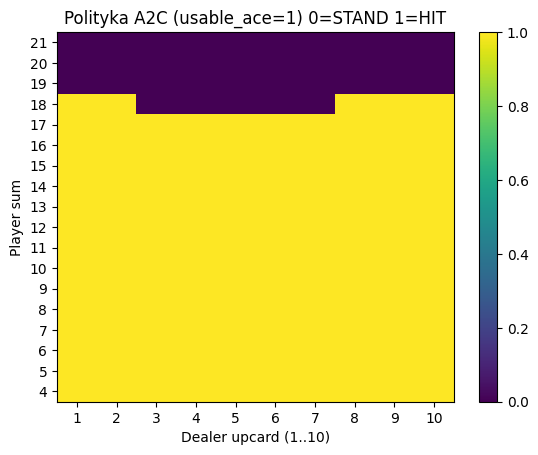

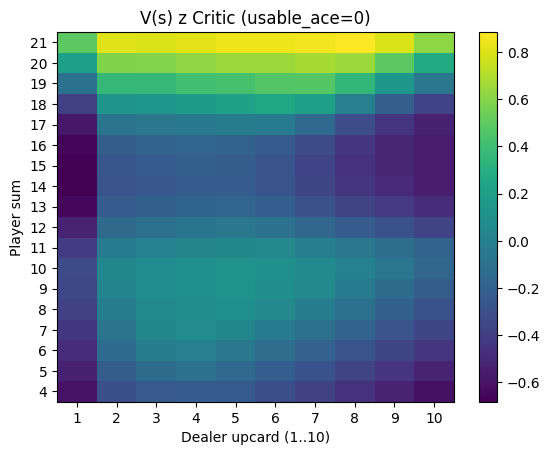

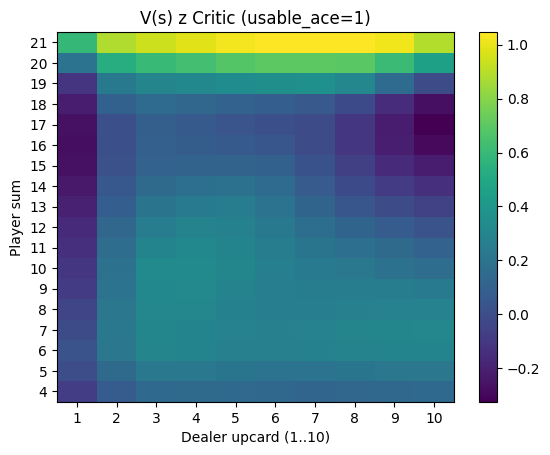

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def policy_action(player_sum, dealer_card, usable_ace):
    return a2c_greedy_action((player_sum, dealer_card, usable_ace))

def plot_policy_heatmap(usable_ace, ps_min=4, ps_max=21):
    sums = np.arange(ps_min, ps_max + 1)
    dealers = np.arange(1, 11)
    grid = np.zeros((len(sums), len(dealers)), dtype=int)
    for i, ps in enumerate(sums):
        for j, dc in enumerate(dealers):
            grid[i, j] = policy_action(ps, dc, usable_ace)
    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"Polityka A2C (usable_ace={usable_ace}) 0=STAND 1=HIT")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum")
    plt.xticks(np.arange(len(dealers)), dealers)
    plt.yticks(np.arange(len(sums)), sums)
    plt.colorbar()
    plt.show()

def plot_value_heatmap(usable_ace, ps_min=4, ps_max=21):
    sums = np.arange(ps_min, ps_max + 1)
    dealers = np.arange(1, 11)
    grid = np.zeros((len(sums), len(dealers)), dtype=float)
    actor.eval()
    critic.eval()
    with torch.no_grad():
        for i, ps in enumerate(sums):
            for j, dc in enumerate(dealers):
                s = (ps, dc, usable_ace)
                v = critic(state_to_tensor(s)).item()
                grid[i, j] = v
    plt.figure()
    plt.imshow(grid, origin="lower", aspect="auto")
    plt.title(f"V(s) z Critic (usable_ace={usable_ace})")
    plt.xlabel("Dealer upcard (1..10)")
    plt.ylabel("Player sum")
    plt.xticks(np.arange(len(dealers)), dealers)
    plt.yticks(np.arange(len(sums)), sums)
    plt.colorbar()
    plt.show()

plot_policy_heatmap(0)
plot_policy_heatmap(1)
plot_value_heatmap(0)
plot_value_heatmap(1)


In [26]:
import numpy as np

def rollout_returns(policy_fn, n_games=200_000):
    rets = np.zeros(n_games, dtype=np.int8)
    for i in range(n_games):
        s, _ = env.reset()
        done = False
        while not done:
            a = policy_fn(s)
            s, r, term, trunc, _ = env.step(a)
            done = term or trunc
        rets[i] = int(r)
    return rets

def bootstrap_ci(x, iters=2000, alpha=0.05):
    x = np.asarray(x, dtype=np.float32)
    n = len(x)
    means = np.empty(iters, dtype=np.float32)
    for i in range(iters):
        samp = np.random.choice(x, size=n, replace=True)
        means[i] = np.mean(samp)
    lo = float(np.quantile(means, alpha/2))
    hi = float(np.quantile(means, 1 - alpha/2))
    return float(np.mean(x)), (lo, hi)

rets_a2c = rollout_returns(lambda s: a2c_greedy_action(s), n_games=100_000)
rets_bs = rollout_returns(lambda s: basic_strategy(s), n_games=100_000)

mean_a2c, ci_a2c = bootstrap_ci(rets_a2c)
mean_bs, ci_bs = bootstrap_ci(rets_bs)

print("A2C mean return:", mean_a2c, "CI95:", ci_a2c)
print("BasicStrategy mean return:", mean_bs, "CI95:", ci_bs)


A2C mean return: -0.05079999938607216 CI95: (-0.05662025138735771, -0.04488924890756607)
BasicStrategy mean return: -0.07868999987840652 CI95: (-0.08496125042438507, -0.07282000035047531)
